- [先说一些废话](#先说一些废话)
- [卡尔曼滤波的应用场景](#卡尔曼滤波的应用场景)
- [一切从一个预测开始](#一切从一个预测开始)
- [如何消弭噪音带来的影响](#如何消弭噪音带来的影响)
  - [对状态的更新](#对状态的更新)
- [噪音、参数与协方差](#噪音参数与协方差)
- [关于卡尔曼增益](#关于卡尔曼增益)
  - [测量矩阵](#测量矩阵)
  - [对系统的初始化](#对系统的初始化)
- [如何计算](#如何计算)
  - [代码实现](#代码实现)
  - [实验结果](#实验结果)


# 先说一些废话

在大多数情况下，当我们的系统中存在大量随机信号，或者说不确定信号的时候，我们可能会需要一种滤波器来帮助我们过滤掉系统中的噪音，除了在先前文章中提到的基于滑动窗口的滤波器，

[信号采样基本概念 —— 4. 移动平均滤波](https://blog.csdn.net/poisonchry/article/details/131158726)
[信号采样基本概念 —— 5. 加权移动平均滤波](https://blog.csdn.net/poisonchry/article/details/131786126)

或者傅立叶变换，或者小波（对这部分内容需要了解的同学请自行翻阅我以前写的内容）；当然也可以使用这篇文章中将要提到的一种重要的滤波算法——卡尔曼滤波。

相较于其他滤波，卡尔曼滤波有很多优点，比如说：

* 最优性：卡尔曼滤波是在最小均方误差准则下进行状态估计的，因此在高斯噪声和线性系统模型下，它能够提供最优的状态估计结果。
* 递归性：卡尔曼滤波是一个递归算法，能够在不断接收新的测量值时实时更新状态估计，适用于实时估计问题。
* 考虑系统模型：卡尔曼滤波利用系统模型来预测状态，并结合测量信息进行估计，因此对于连续变化的动态系统，它的预测效果较好。
* 适用范围广：卡尔曼滤波可应用于线性和近似线性的系统，且对高斯噪声的处理效果较好。

当然，它也有一些缺点：

* 对非线性问题的限制：卡尔曼滤波最初是设计用于线性系统，对于非线性系统的处理需要引入扩展卡尔曼滤波（EKF）或其他非线性滤波方法，这增加了计算复杂度。
* 对噪声分布假设：卡尔曼滤波假设噪声是高斯分布的，当实际噪声不符合高斯分布时，效果可能不理想。

# 卡尔曼滤波的应用场景

那么接下来我们来看看卡尔曼滤波一般应用在哪些场景。

* 系统状态是连续变化的：卡尔曼滤波适用于那些系统状态是连续变化的问题，例如目标跟踪、机器人定位、移动物体追踪等。
* 测量受到噪声干扰：卡尔曼滤波能够有效地处理测量过程中的噪声，可以提供对系统状态更准确的估计。
* 系统具有线性或近似线性的动态特性：卡尔曼滤波最初是为线性系统设计的，但在某些情况下，它也可以用于近似线性系统。
* 需要实时估计：卡尔曼滤波是一个递归算法，能够在不断接收新的测量值时实时更新状态估计，因此适合于实时估计问题。
* 系统噪声和测量噪声符合高斯分布：卡尔曼滤波假设噪声是高斯分布的，因此在应用之前，需要对噪声进行合理的建模。

# 一切从一个预测开始

我们假设有一个简单的移动物体，当我们想要估计它某个时刻后的位置。可以通过以下运动方程计算：

$$
\begin{cases}
 P_t = P_{t-1} + v_{t-1} \Delta t + \frac{1}{2}u_t \Delta t^2 \\
 V_t = V_{t-1} + u_t \times \Delta t
\end{cases}
$$

因为这个是线性方程，所以我们可以用矩阵形式进行表示：

$$
\begin{bmatrix}
P_t  \\
V_t
\end{bmatrix} = \begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix} \cdot \begin{bmatrix}
P_{t-1} \\
V_{t-1}
\end{bmatrix} + \begin{bmatrix}
\frac{\Delta t^2}{2} \\
\Delta t
\end{bmatrix} u_t
$$

如果我们分别令 $\mathbf F=\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}$ 以及 $\mathbf B=\begin{bmatrix}
\frac{\Delta t^2}{2} \\
\Delta t
\end{bmatrix}$ 于是上述公式就又可以被进一步简化为：

$$
\hat x_t = \mathbf F \hat x_{x-1} + \mathbf B u_t
$$

这样我们得到了一个可以通过过去的状态 $\hat x_{t-1}$ 预测下一个状态的 $\hat x_t$ 的`状态预测公式`。其中的 $\mathbf F$ 有个称呼——`状态转移矩阵`，它可以让我们通过上一个状态控制下一个状态； $\mathbf B$ 被称为 `控制矩阵`，表示控制变量 $u$ 如何作用于这个线性系统的。

假设系统是一个完美系统，那么当 $\hat x = x$ 时，也就是说这个预测出的结果就是系统经过 $\Delta t$ 后的实际结果。但现实中，我们存在很多噪音。比如观测带来的误差，传感器精度的误差等。

# 如何消弭噪音带来的影响

所以，如果一旦参数含有噪音，而我们在计算的过程中，如果不考虑这些噪音带来的影响。那么误差会持续累积，并导致在某一刻出现巨大的误差。所以为了尽可能校准这个误差带来的影响，过去在统计中会通过把多次实验结果的放在一起，于是有

$$
\hat z = \frac{1}{n} (z_0 + z_1 + \dots + z_n) = \frac{1}{n} \sum z_i
$$

获得一个平均值后，能够最大程度抑止噪音。如果我们的系统是恒定的，也就是说没有其他输入影响结果的情况下，那么当实验结果累加到某一时刻，噪音对于系统的影响将忽略不计，所以一定会有 $\hat x_{n+1} = \hat x_{n}$。

但是这种计算方式有一个致命的缺点，我们为了得到这个理想均值，需要保留大量的前置计算内容，所以当这个系统的表述公式过于复杂时，这会导致我们出现较大的内存开销。因此我们能不能对上述公式进行优化，使得我们只需要保留最少的信息量，也能得到这个目标期望呢？

## 对状态的更新

答案显然是可行的，现在我们回到之前的方程

$$
\hat x = \frac{1}{n} \sum_{i=1}^{n} z_i = \frac{1}{n} (\sum_{i=1}^{n-1} z_i + z_n)
$$

然后

$$
= \frac{1}{n} \sum_{i=1}^{n-1} z_i  + \frac{1}{n} z_n
$$

然后，我们给求和 $\sum$ 部分乘以一个 $\frac{n-1}{n-1}$，于是

$$
= \frac{1}{n} \frac{n-1}{n-1} \sum_{i=1}^{n-1} z_i  + \frac{1}{n} z_n
$$

然后我们调换一个顺序

$$
= \frac{n-1}{n} \frac{1}{n-1}  \sum_{i=1}^{n-1} z_i + \frac{1}{n} z_n
$$

这里的 $\frac{1}{n-1}  \sum_{i=1}^{n-1} z_i$ 显然是 $\hat x_{n-1}$，即上一刻的估测值，于是

$$
= \frac{n-1}{n} \hat x_{n-1} + \frac{1}{n} z_n
$$

然后把上式拆开，于是

$$
= \hat x_{n-1} - \frac{1}{n} \hat x_{n-1} + \frac{1}{n} z_n
$$

然后再稍微整理一下

$$
= \hat x_{n-1} + \frac{1}{n} (z_n - \hat x_{n-1} )
$$

因此，本次实验的预估值就可以表示为以下形式：

![在这里插入图片描述](https://img-blog.csdnimg.cn/f4c0d5c253114f2097e6701b8cdd6161.png#pic_center)
然后我们换一个更通用的形式表示，即：

$$
\hat x_n = \hat x_{n-1} + k_n (z_n - \hat x_{n-1})
$$

而该方程又被称为 `状态更新方程`。其中，$(z_n - \hat x_{n-1})$ 又被称为 `测量残差`，而 $k_n$ 这个则是 `卡尔曼增益（Kalman Gain）`。

# 噪音、参数与协方差

由于系统性的噪音（测量的误差、传感器的误差等），所以必然导致测量结果与理论值之间存在偏差，因此大多数情况下，如果统计测量值的分布，是一个近似高斯函数的分布。

![在这里插入图片描述](https://img-blog.csdnimg.cn/51eeed94d4624536950bb7fd769445a7.png#pic_center)

同理、如果作为系统输入的参数也可能有这样的分布，例如本例中的速度、位置。所以如果把这两个变量作为输入参数的两个维度，并标记样本，我们有可能得到这样的图。


![在这里插入图片描述](https://img-blog.csdnimg.cn/5139322327bb437da16efc7ef16ce36b.png#pic_center)

或者下面两幅图其中之一

![在这里插入图片描述](https://img-blog.csdnimg.cn/d7c62282bf0a4907b335cb76fb1aaeb1.png#pic_center)

无论投影到任意维度上，都符合高斯分布。但是如果计算协方差的话这显然不一样。

对于图一的情况 $cov(X,Y) = 0$ ，而第二种情况则 $cov(X,Y) > 0$，第三种情况的协方差为 $cov(X,Y) < 0$。

我们之所以要使用协方差，是因为作为系统输入的变量之间存在着一些关联，比如当某个参数噪音变大的时候，另一个参数也通常会发生改变，所以如果使用协方差的话，能够帮助我们判断噪音对参数的影响。

那么现在我们希望对于连续系统，这些不确定性能够传递。那么根据`协方差的传播率`

$$
cov(Ax, By) = A cov(x, y) B^T
$$

我们可以得到

$$
P_t = FP_{t-1}F^T
$$

其中 $F=\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}$，即状态转移矩阵。然后考虑再加入一些噪音函数 $Q$，于是

$$
P_t = FP_{t-1}F^T + Q
$$

我们得到了—— `预测估计协方差矩阵`。

# 关于卡尔曼增益

在卡尔曼滤波中，最后一个步骤是将预测的状态估计与测量值相结合，得到最优的状态估计。这就是“卡尔曼增益”这个概念发挥作用的地方。卡尔曼增益决定了在更新状态估计时，应该给预测的状态估计和测量值分别多大的权重。

卡尔曼增益的推导使用了贝叶斯估计原理。在卡尔曼滤波中，我们有一个动态系统，包含一个状态向量 x 和一个观测向量 z，我们希望根据测量值 z 来估计系统的状态 x。下面是卡尔曼增益的计算过程：

1. **预测步骤**：在预测步骤中，我们使用系统模型来根据先前的状态估计和系统的动态预测状态 $x'$ 和预测的协方差矩阵 $P'$。
2. **测量更新步骤**：在测量更新步骤中，我们将预测的状态 $x'$ 与实际测量值 $z$ 结合，得到更新后的状态估计 $x$ 和更新后的协方差矩阵 $P$。

即使用如下公式——`卡尔曼增益`：

$$
K = \frac{P' \cdot H^T}{H \cdot P' \cdot H^T + R}
$$

其中：

* K 是卡尔曼增益。
* P' 是预测步骤中得到的预测协方差矩阵。
* H 是测量矩阵，它将状态空间映射到测量空间。它将状态 x' 转换为预期的测量值 z'。简单地说，它告诉我们如何将状态转换为预期的测量结果。
* R 是测量噪声的协方差矩阵。它表示测量的不确定性或误差。

卡尔曼增益在测量更新步骤中起着至关重要的作用。它决定了预测的状态估计和测量值之间的权衡。如果测量值非常可靠（噪声较小），卡尔曼增益将较大，测量值将对更新后的状态估计产生较大的影响。另一方面，如果测量值存在噪声或不确定性，卡尔曼增益将较小，更多的权重将放在预测的状态估计上。

最后，更新后的状态估计和协方差矩阵的计算如下：

$$
x = x' + K \cdot (z - H \cdot x') 
$$

$$
P = (I - K \cdot H) \cdot P'
$$

其中：

* x 是更新后的状态估计。
* I 是单位矩阵。
* z 是实际测量值。

卡尔曼增益对于在卡尔曼滤波中实现最优状态估计至关重要。它使滤波器能够适应系统的动态变化，并有效地结合预测和测量。这就是为什么卡尔曼滤波在各种应用中被广泛使用，特别是在处理不确定或噪声较大的系统时。

## 测量矩阵

你可能注意到这里引入了一个新的概念——测量矩阵（Measurement Matrix）。

它是卡尔曼滤波中的一个关键组成部分。它是一个线性变换矩阵，用于将系统的状态向量映射到测量空间，从而将状态空间的估计与实际的测量值联系起来。

在卡尔曼滤波中，我们通常使用传感器或测量设备来获得系统的实际测量值。这些测量值通常与系统的状态之间存在一定的关联，但可能不是直接可观测的。测量矩阵的作用就是建立这种关联关系，将状态向量与测量空间之间的映射关系描述出来。

测量矩阵通常用符号 H 表示。它的大小是 m × n，其中 m 是测量向量的维数（即实际测量的数量），n 是状态向量的维数（即系统的状态数量）。测量矩阵定义了如何从系统状态中提取出与实际测量相对应的部分。

假设我们有一个状态向量 x 和一个测量向量 z，它们之间的关系可以用测量矩阵 H 表示为：

$$
z = H \cdot x
$$

测量矩阵 H 的值取决于具体的应用场景和传感器配置。在每次测量更新步骤中，卡尔曼滤波器将预测的状态向量 x' 通过测量矩阵 H 映射到测量空间得到预测的测量值 z'，然后与实际测量值 z 进行比较，通过计算测量残差（实际测量值与预测测量值之间的差异）来更新状态估计。

测量矩阵在卡尔曼滤波中起到了非常重要的作用，它是将系统的状态估计与实际测量值联系起来的桥梁，使得滤波器能够有效地利用测量信息来进行状态估计。
## 对系统的初始化

另外在我们开始用卡尔曼滤波之前，我们还需要考虑另外一个情况。首先回到初始状态，即 $i=1$，于是状态更新方程变成了下面这个样子：

$$
\hat x_1 = \hat x_{0} + K_n (z_1 - \hat x_{0})
$$

那么这里就出现了问题，由于 $\hat x_0$ 并不存在，所以我们需要假设这个值。通常情况下我们把系统参数全部设置为0来作为`初始条件`。

# 如何计算

卡尔曼滤波，总的来说一共要用到五个函数。在完成了前面内容的介绍后，现在我们来看看这五个公式是怎样使用，并完成滤波的。

首先我们假设我们已经对全部参数进行了假设，并已经获得了初始条件 $x_0$。

**预测阶段**

现在我们要开始进行对 $x_1$ 状态进行预测。由于该系统只包含了速度$v$和位置$p$，所以对于状态$x_0$就有了

$$
x_0 = \begin{bmatrix}
P_t  \\
V_t
\end{bmatrix}
$$

然后我们分别使用`状态预测公式` $\hat x_t = \mathbf F \hat x_{x-1} + \mathbf B u_t$ 获得下一个状态 $\hat x_1^-$ ；

以及`预测估计协方差矩阵` $P_t = FP_{t-1}F^T + Q$ 获得下一个 $P_1^-$。

注意此刻的 $\hat x_1^-$ 以及$P_1^-$ 都只是估测值。

**更新阶段**

然后计算`卡尔曼增益` $K = \frac{P' \cdot H^T}{H \cdot P' \cdot H^T + R}$

得到了卡尔曼增益后，带入状态更新方程 $\hat x_n = \hat x_{n-1} + K (z_n -H \hat x_{n-1})$ 得到更新后的 $\hat x_1^+$

以及 $P = (I - K \cdot H) \cdot P'$ 得到 $P_1^+$。

此刻得到的 $\hat x_1^+$ 和 $P_1^+$ 就是最佳估计值了。那么接下来我们看看具体的代码怎么实现。

## 代码实现

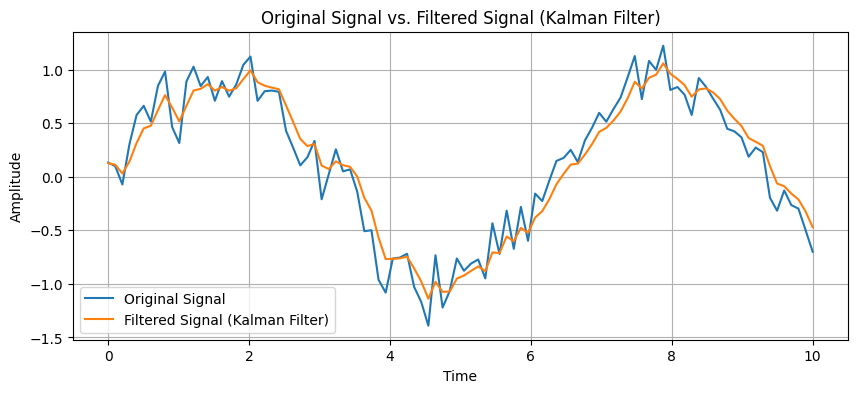

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_filter(signal, initial_state_estimate, initial_estimate_covariance, process_noise_covariance, measurement_noise_covariance):
    state_estimate = initial_state_estimate
    estimate_covariance = initial_estimate_covariance
    filtered_signal_estimates = []

    for measurement in signal:
        # 预测步骤（时间更新）
        state_estimate = np.dot(state_transition_matrix, state_estimate)
        estimate_covariance = np.dot(np.dot(state_transition_matrix, estimate_covariance), state_transition_matrix.T) + process_noise_covariance

        # 更新步骤（测量更新）
        innovation = measurement - np.dot(measurement_matrix, state_estimate)
        innovation_covariance = np.dot(np.dot(measurement_matrix, estimate_covariance), measurement_matrix.T) + measurement_noise_covariance
        kalman_gain = np.dot(np.dot(estimate_covariance, measurement_matrix.T), np.linalg.inv(innovation_covariance))

        state_estimate = state_estimate + np.dot(kalman_gain, innovation)
        estimate_covariance = estimate_covariance - np.dot(np.dot(kalman_gain, measurement_matrix), estimate_covariance)

        # 将滤波后的信号估计值保存到列表中
        filtered_signal_estimates.append(state_estimate[0])

    return np.array(filtered_signal_estimates)

# 生成示例信号
t = np.linspace(0, 10, 100)  # 时间轴
signal = np.sin(t) + np.random.randn(100) * 0.2  # 添加噪声的正弦信号

# 定义卡尔曼滤波器的参数
initial_state_estimate = np.array([0.0])  # 初始状态估计值
initial_estimate_covariance = np.eye(1)  # 初始状态估计的协方差矩阵
process_noise_covariance = np.diag([0.01])  # 过程噪音协方差矩阵
measurement_noise_covariance = 0.04  # 测量噪音的方差

# 定义卡尔曼滤波器的状态转移矩阵和测量模型
state_transition_matrix = np.array([[1.0]])
measurement_matrix = np.array([[1.0]])

# 使用卡尔曼滤波器对信号进行滤波
filtered_signal = kalman_filter(signal, 
				initial_state_estimate, 
				initial_estimate_covariance, 
				process_noise_covariance,
				measurement_noise_covariance)

# 绘制原始信号和滤波后的信号
plt.figure(figsize=(10, 4))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, filtered_signal, label='Filtered Signal (Kalman Filter)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original Signal vs. Filtered Signal (Kalman Filter)')
plt.legend()
plt.grid(True)
plt.show()